In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [10]:
adata=sc.read('mi_dropseq/adata_base.h5ad')

In [11]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)

In [12]:
cell_annotation= pd.read_table('matrix_mixology/sc_dropseq.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [13]:
sc.tl.umap(adata)

In [6]:
adata.write('beta_parameter/adata_dropseq.h5ad')

... storing 'cell_line' as categorical


In [2]:
adata=sc.read('beta_parameter/adata_dropseq.h5ad')

In [28]:
g = gt.Graph(directed=False)
adj=adata.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [29]:
pickle.dump(g,open('beta_parameter/g_dropseq.pkl','wb'),2)

In [14]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

39.881672620773315

In [11]:
pickle.dump(state1,open('beta_parameter/state1_dropseq.pkl','wb'),2)
pickle.dump(state2,open('beta_parameter/state2_dropseq.pkl','wb'),2)
pickle.dump(state3,open('beta_parameter/state3_dropseq.pkl','wb'),2)

In [3]:
state1=pickle.load(open('beta_parameter/state1_dropseq.pkl','rb'))
state2=pickle.load(open('beta_parameter/state2_dropseq.pkl','rb'))
state3=pickle.load(open('beta_parameter/state3_dropseq.pkl','rb'))

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


<IPython.core.display.Javascript object>


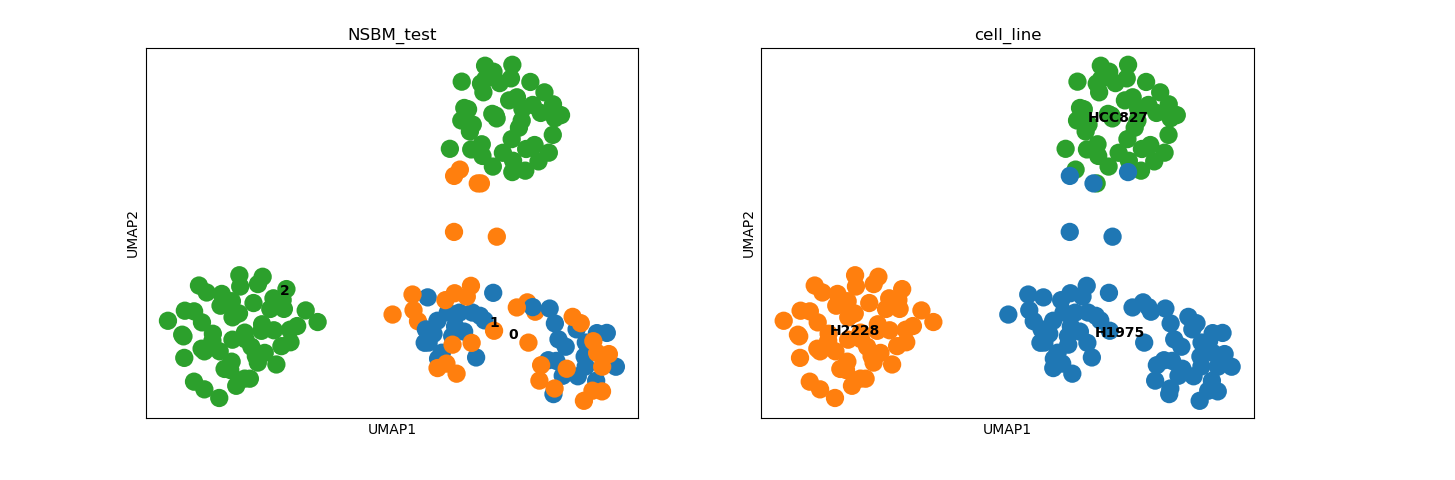

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,36,0,0
1,35,0,2
2,1,56,43


In [31]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### sweep

In [26]:
bs = state2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
a=time.time()
state=state1.copy(bs=bs, sampling=True)
state.mcmc_sweep(niter=10000)
b=time.time()
print(b-a)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


3.3979010581970215


<NestedBlockState object, with base <BlockState object with 13 blocks (12 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f915b7cc910>, at 0x7f915b624390>, and 10 levels of sizes [(173, 12), (12, 4), (4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f915b6240d0>

In [13]:
pickle.dump(state,open('beta_parameter/state2_sweep_dropseq.pkl','wb'),2)

In [27]:
states2=pickle.load(open('beta_parameter/state1_sweep_dropseq.pkl','rb'))

<IPython.core.display.Javascript object>


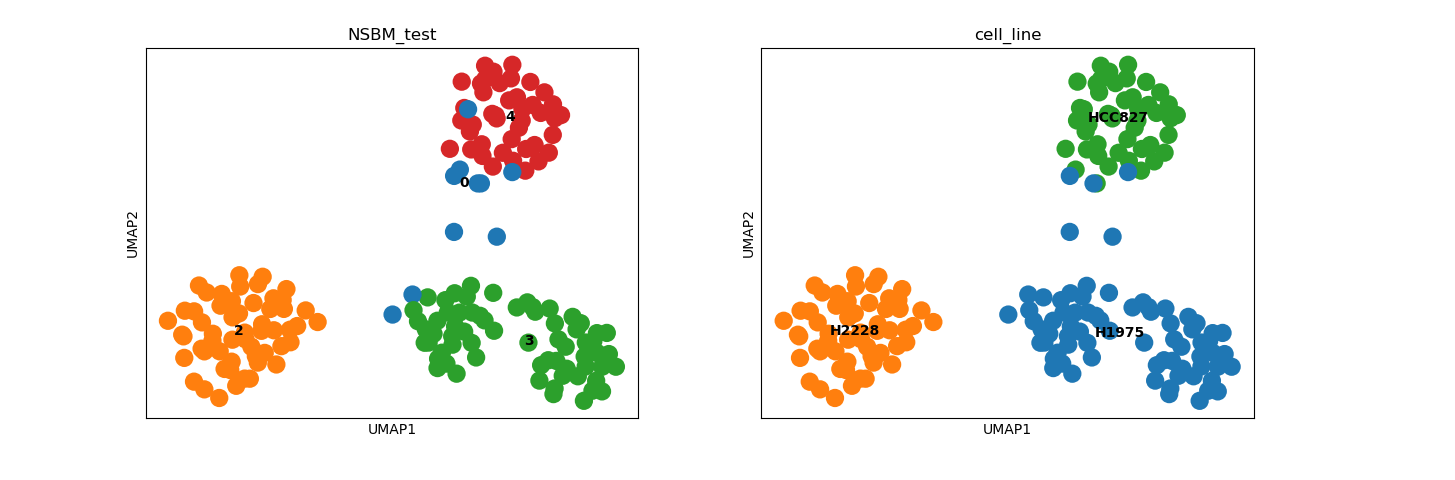

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,7,0,3
2,0,56,0
3,65,0,0
4,0,0,42


In [28]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(states2.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### equilibrate

In [15]:
bs = states1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=states1.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(state,wait=1000, nbreaks=2,epsilon=0,mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state1_equilibrate_post_sweep_dropseq.pkl','wb'),2)
state

100.43299174308777


<NestedBlockState object, with base <BlockState object with 80 blocks (14 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f91603e3cd0>, at 0x7f9160281510>, and 10 levels of sizes [(173, 14), (14, 6), (6, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f9160281490>

In [16]:
estate1=pickle.load(open('beta_parameter/state1_equilibrate_post_sweep_dropseq.pkl','rb'))

<IPython.core.display.Javascript object>


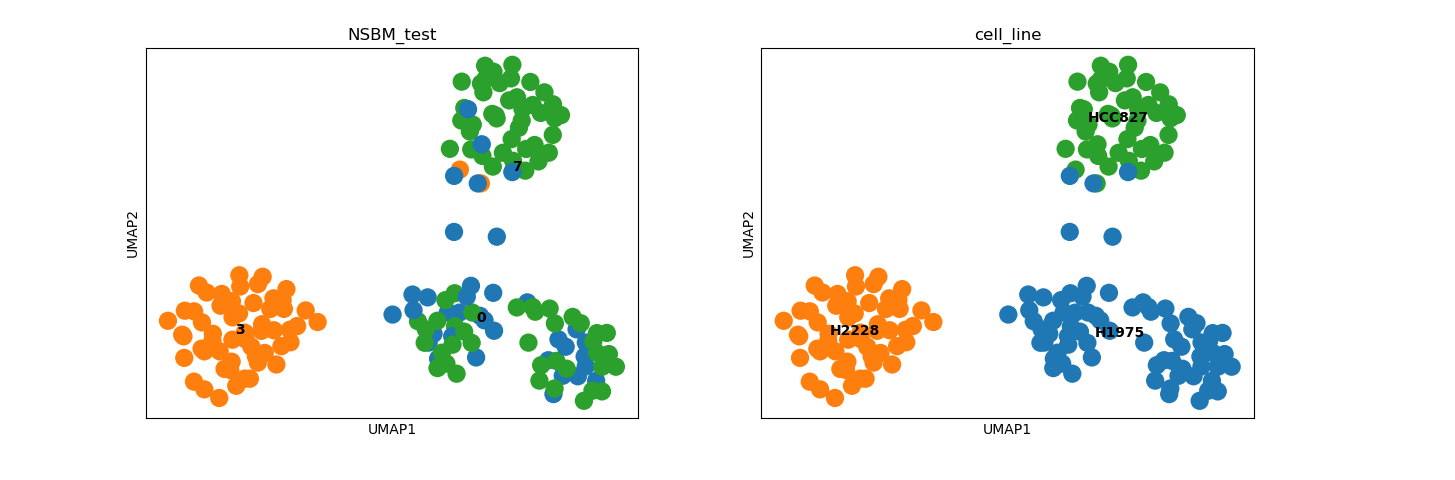

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,34,0,2
3,0,56,2
7,38,0,41


In [18]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate1.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# anneal state1

In [11]:
bs = state1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=state1.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(nbreaks=3))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state1_anneal100_10a_dropseq_nbreaks3.pkl','wb'),2)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


129.00292086601257


<NestedBlockState object, with base <BlockState object with 79 blocks (15 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f05121ad210>, at 0x7f04f827c190>, and 10 levels of sizes [(173, 15), (15, 4), (4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f04f827c250>

In [12]:
statesniter=pickle.load(open('beta_parameter/state1_anneal100_10a_dropseq_nbreaks3.pkl','rb'))

<IPython.core.display.Javascript object>


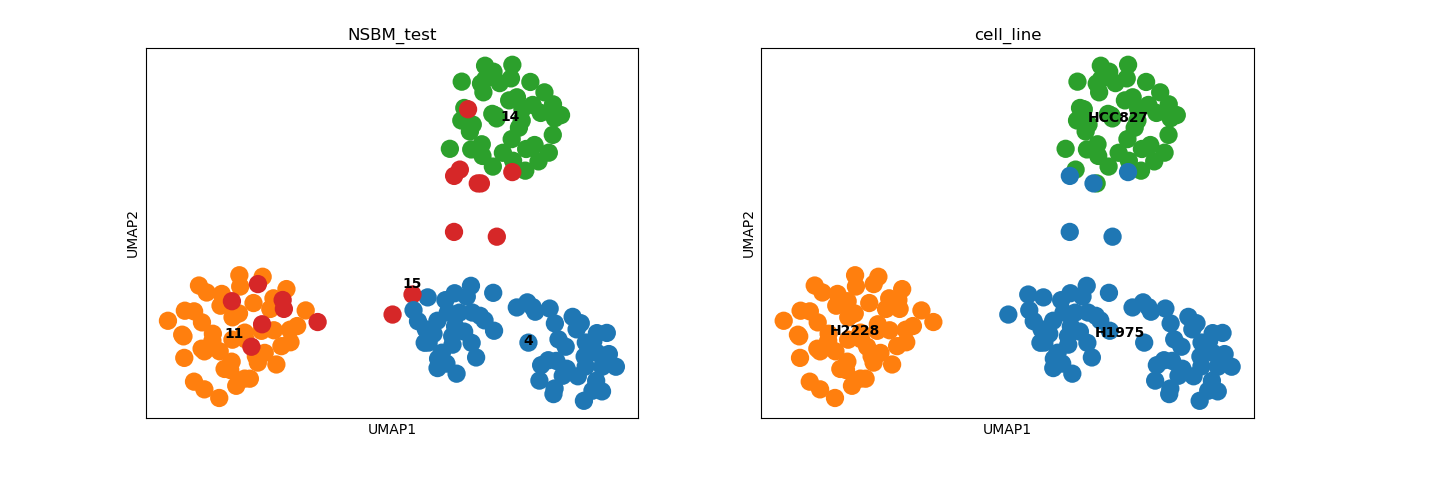

cell_line,H1975,H2228,HCC827
NSBM_test,,,
4,65,0,0
11,0,49,0
14,0,0,42
15,7,7,3


In [13]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(statesniter.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [19]:
bs = estate1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=estate1.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=10)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state1_anneal100_10a_dropseq_posteq_postsweep.pkl','wb'),2)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


123.5861325263977


<NestedBlockState object, with base <BlockState object with 79 blocks (15 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f916022ff10>, at 0x7f91600e71d0>, and 10 levels of sizes [(173, 15), (15, 5), (5, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f91600e7150>

In [20]:
state100_10a=pickle.load(open('beta_parameter/state1_anneal100_10a_dropseq_posteq_postsweep.pkl','rb'))

<IPython.core.display.Javascript object>


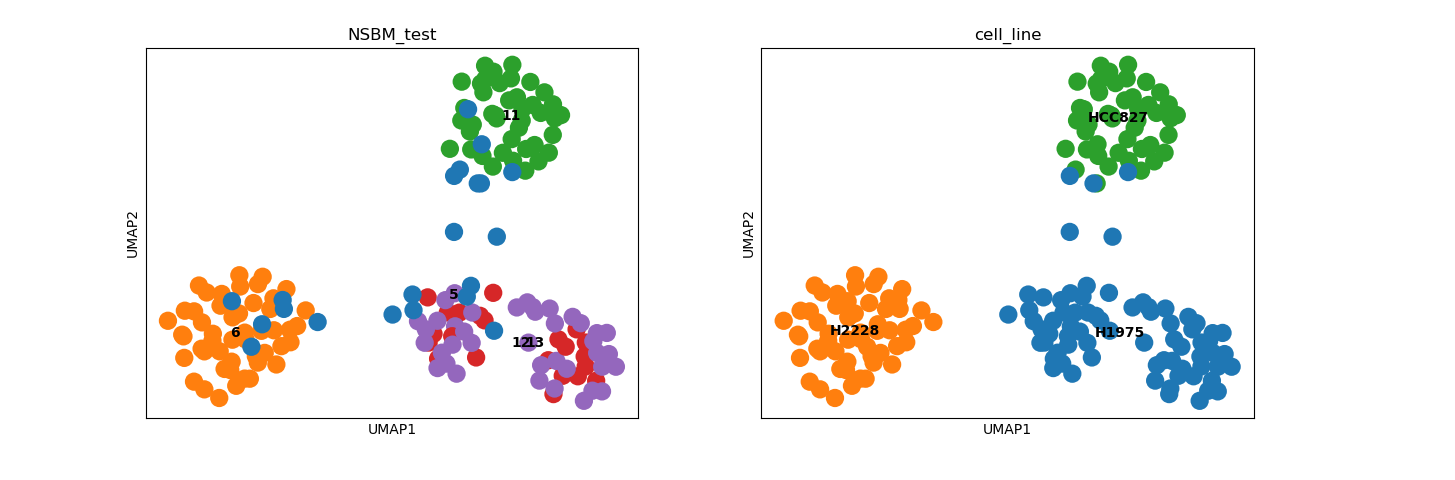

cell_line,H1975,H2228,HCC827
NSBM_test,,,
5,11,6,4
6,0,50,0
11,0,0,41
12,22,0,0
13,39,0,0


In [21]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_10a.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# altro approccio

In [27]:
a=time.time()
bs = state1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = gt.NestedBlockState(g,bs = bs)

state=state.copy(bs=bs, sampling=True)
gt.mcmc_anneal(state, beta_range=(1, 10), niter=1000, mcmc_equilibrate_args=dict(force_niter=10))
b=time.time()
print(c)
pickle.dump(state,open('beta_parameter/state_greedy_dropseq.pkl','wb'),2)
state

47.39663028717041


<NestedBlockState object, with base <BlockState object with 14 blocks (13 nonempty), degree-corrected, for graph <Graph object, undirected, with 173 vertices and 3675 edges at 0x7f9ae5b60450>, at 0x7f9ae5a9cc10>, and 10 levels of sizes [(173, 13), (13, 5), (5, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f9b3971db90>

In [28]:
state_greedy=pickle.load(open('beta_parameter/state_greedy_dropseq.pkl','rb'))

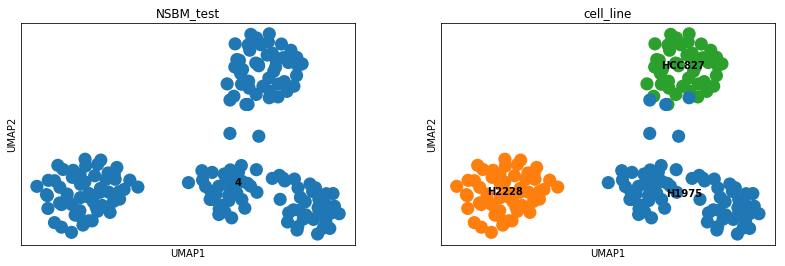

cell_line,H1975,H2228,HCC827
NSBM_test,,,
4,72,56,45


In [30]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state_greedy.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)